In [95]:
from typing import TypedDict, Annotated
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display
from pydantic import BaseModel, Field
import operator

load_dotenv()

True

In [96]:
class EssayFeedback(BaseModel):
    feedback: str = Field(description="This field is for essay about a topic")
    score: float = Field(description="This is a score field for the essay", ge=0, lt=10)


In [97]:
gpt_llm = ChatOpenAI(model="gpt-4o-mini")

structured_model=gpt_llm.with_structured_output(EssayFeedback)

In [98]:
class Essay(TypedDict):
    topic: str
    essay: str
    language_feedback: str
    depth_of_analysis: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float



In [99]:
def essay_generator(state: Essay) -> Essay:
    topic=state['topic']
    prompt= f"You are an AI assistant who will generate a bad essay on the topic: \n {topic}"
    essay=gpt_llm.invoke(prompt)
    state['essay']=essay
    return state

In [100]:
def language_feedback(state: Essay) -> Essay:
    essay=state['essay']
    prompt= f"Provide a language feedback for the essay and also assign score between (0-10) for: \n {essay}"
    response=structured_model.invoke(prompt)
    return {'language_feedback':response.feedback,'individual_scores':[response.score]}

In [101]:
def depth_of_analysis(state: Essay) -> Essay:
    essay=state['essay']
    prompt= f"Provide your depth of analysis for the essay and also assign also assign score between (0-10) for: \n {essay}"
    response=structured_model.invoke(prompt)
    return {'depth_of_analysis':response.feedback,'individual_scores':[response.score]}

In [102]:
def clarity_feedback(state: Essay) -> Essay:
    essay=state['essay']
    prompt= f"Provide your clarity feedbacl for the essay and also assign also assign score between (0-10) for: \n {essay}"
    response=structured_model.invoke(prompt)
    return {'clarity_feedback':response.feedback,'individual_scores':[response.score]}

In [ ]:
def overall_feedback(state: Essay) -> Essay:
    prompt =  f"Based on the following feedback, create summarized feedback \n language feedback: \n {state['language_feedback']} \n depth of analysis: \n {state['language_feedback']} \n Clarity Feedback: \n {state['clarity_feedback']}"
    
    overall_feedback=gpt_llm.invoke(prompt)
    avg_score=sum(state['individual_scores'])/len(state['individual_scores'])

    # state['overall_feedback']=overall_feedback
    # state['avg_score']=avg_score

    return {'overall_feedback':overall_feedback, 'avg_score':avg_score}
    


In [115]:
graph = StateGraph(Essay)
graph.add_node("essay_generator",essay_generator)
graph.add_node("language_feedback",language_feedback)
graph.add_node("depth_of_analysis",depth_of_analysis)
graph.add_node("clarity_feedback",clarity_feedback)
graph.add_node("overall_feedback",overall_feedback)

graph.add_edge(START,"essay_generator")
graph.add_edge("essay_generator","language_feedback")
graph.add_edge("essay_generator","depth_of_analysis")
graph.add_edge("essay_generator","clarity_feedback")
graph.add_edge("language_feedback","overall_feedback")
graph.add_edge("depth_of_analysis","overall_feedback")
graph.add_edge("clarity_feedback","overall_feedback")
graph.add_edge("overall_feedback",END)

workflow=graph.compile()


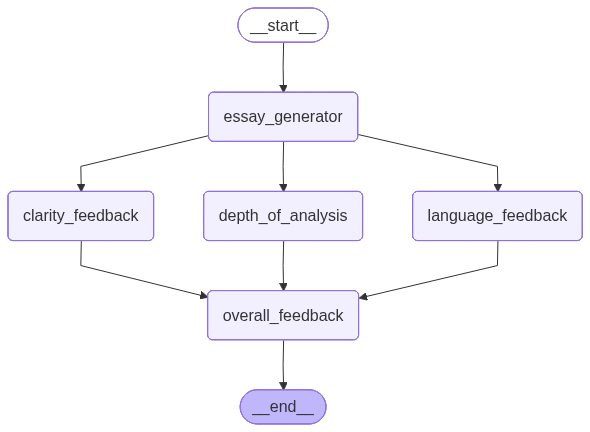

In [116]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [117]:
# final_result=
workflow.invoke({"topic":"Rise of India in Tech"})
# print(final_result)
# print(50*"=")
# print(final_result['overall_feedback'])
# print(50*"=")
# print(final_result['avg_score'])

{'topic': 'Rise of India in Tech',
 'essay': AIMessage(content="**The Rise of India in Tech: A Bad Essay**\n\nIndia has been rising in the tech industry lately, and it’s really interesting. In fact, many people say it's becoming a tech hub. This is mainly because of the internet, which is like a big network of computers that connects people. Thanks to the internet, more people in India can access information, which is good. \n\nThe Indian government has supported this tech rise by making policies, but I’m not sure what these policies are. Maybe they involve giving money, or perhaps they make it easier for startups? Startups are like small businesses that are new and cool. They usually work on apps and websites. One famous example is some app that everyone seems to have but I can’t remember the name of it right now. It’s very popular, though.\n\nAnother important point is that many people in India are smart and can code. Coding is when you write things that computers understand. It’s li